<a href="https://colab.research.google.com/github/injoon-pij/dlnlp-learning/blob/main/dlnlp_rnn(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) RNNLM (Recurrent Neural Network Language Model)

* n-gram 언어 모델과 NNLM(Neural Network LM)은 고정된 개수의 단어만을 입력으로 받아야한다는 단점이 존재
* 시점(time step)이라는 개념이 도입된 RNN으로 언어 모델을 만들면 입력의 길이를 고정하지 않아도 됨

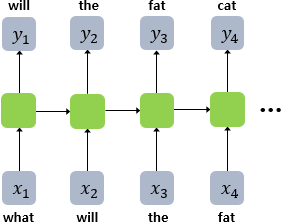

* RNNLM은 기본적으로 예측 과정에서 이전 시점의 출력을 현재 시점의 입력으로 함 
 * (ex) what을 입력받으면, will을 예측하고 이 will은 다음 시점의 입력이 되어 the를 예측. 그리고 이 또한 다시 다음 시점의 입력이 됨
 * 결과적으로 네번째 시점의 cat은 앞서 나온 what, will, the, fat이라는 시퀀스로 인해 결정된 단어

* 위 과정은 훈련이 끝난 모델의 테스트 과정에 대한 설명
* 훈련 과정에서는 이전 시점의 예측 결과를 다음 시점의 입력으로 넣으면서 매번 예측하는 것이 아니라 ___what will the fat cat sit on___라는 훈련 샘플이 있다면, ___what will the fat cat sit___ 시퀀스를 모델의 입력으로 넣었을 때, ___will the fat cat sit on___를 예측하도록 훈련함
 * will, the, fat, cat, sit, on는 각 시점의 레이블
 * 이러한 RNN 훈련 기법을 교사 강요(teacher forcing)라고 함
  
* __교사 강요(teacher forcing)__ : 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법
  * 훈련과정에서 교사 강요를 사용할 경우, 모델이 t 시점에서 예측한 값을 t+1 시점에 입력으로 사용하지 않고, t 시점의 레이블. 즉, 실제 알고있는 정답을 t+1 시점의 입력으로 사용함
  *훈련 과정에서도 이전 시점의 출력을 다음 시점의 입력으로 사용하면서 훈련 시킬 수도 있지만 이는 한 번 잘못 예측하면 뒤에서의 예측까지 영향을 미쳐 훈련 시간이 느려지게 되므로 교사 강요를 사용하면 RNN을 좀 더 빠르고 효과적으로 훈련시킬 수 있음

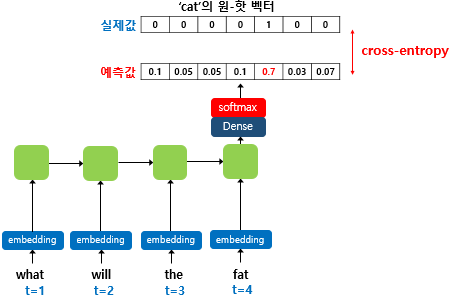

[t = 4 인 경우 RNNLM 동작 구조] (입력 단어 : __'fat'__)

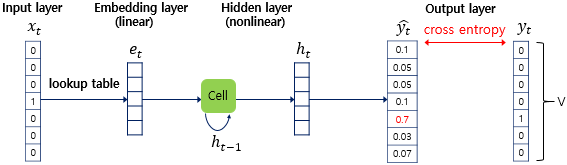

# 2) Text Generation using RNN

다대일(many-to-one) 구조의 RNN을 사용하여 문맥을 반영해서 텍스트를 생성

## 2.1 SimpleRNN

### 2.1.1 Data preprocessing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical

In [ ]:
text="""경마장에 있는 말이 뛰고 있다\n
그의 말이 법이다\n
가는 말이 고와야 오는 말이 곱다\n"""

In [ ]:
# 단어 집합 생성

t = Tokenizer()
t.fit_on_texts([text])
vocab_size = len(t.word_index)
print('단어 집합의 크기 : %d' % vocab_size)
print(t.word_index)

단어 집합의 크기 : 11
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [ ]:
# 훈련 데이터 생성

sequences = []
for line in text.split('\n'):
    encoded = t.texts_to_sequences([line])[0]
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

print('학습에 사용할 샘플의 개수: %d' % len(sequences))
print(sequences)

학습에 사용할 샘플의 개수: 11
[[2, 3], [2, 3, 1], [2, 3, 1, 4], [2, 3, 1, 4, 5], [6, 1], [6, 1, 7], [8, 1], [8, 1, 9], [8, 1, 9, 10], [8, 1, 9, 10, 1], [8, 1, 9, 10, 1, 11]]


* 아직 레이블로 사용될 단어를 분리하지 않았으므로 전체 훈련 데이터에 대해서 맨 우측에 있는 단어에 대해서만 레이블로 분리해야 함

In [ ]:
max_len=max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

샘플의 최대 길이 : 6


In [ ]:
# 가장 긴 샘플의 길이를 기준으로 패딩을 사용하여 길이를 일치시켜 줌
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')

In [ ]:
print(sequences) # 0은 패딩 토큰

[[ 0  0  0  0  2  3]
 [ 0  0  0  2  3  1]
 [ 0  0  2  3  1  4]
 [ 0  2  3  1  4  5]
 [ 0  0  0  0  6  1]
 [ 0  0  0  6  1  7]
 [ 0  0  0  0  8  1]
 [ 0  0  0  8  1  9]
 [ 0  0  8  1  9 10]
 [ 0  8  1  9 10  1]
 [ 8  1  9 10  1 11]]


In [ ]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

In [ ]:
print(X)

[[ 0  0  0  0  2]
 [ 0  0  0  2  3]
 [ 0  0  2  3  1]
 [ 0  2  3  1  4]
 [ 0  0  0  0  6]
 [ 0  0  0  6  1]
 [ 0  0  0  0  8]
 [ 0  0  0  8  1]
 [ 0  0  8  1  9]
 [ 0  8  1  9 10]
 [ 8  1  9 10  1]]


In [ ]:
print(y) # 모든 샘플에 대한 레이블

[ 3  1  4  5  1  7  1  9 10  1 11]


In [ ]:
y = to_categorical(y, num_classes=vocab_size+1) # 정수 인코딩된 단어 집합의 인덱스 : 1 ~ 11

* 단어 집합의 인덱스가 0이 아닌 1부터 시작했으므로, 인덱스가 0부터 시작하는 원핫-인코딩 배열 생성을 위해서 배열의 크기를 실제 단어 집합의 크기보다 +1 된 값으로 설정

In [ ]:
print(y)

[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


### 2.1.2 Modeling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

In [ ]:
model = Sequential()
# 단어집합에는 없는 패딩 토큰의 인덱스 0이 입력 데이터에 포함되어 있으므로 vocab_size+1
# 각 샘플에서 레이블 데이터를 분리하였으므로 데이터의 길이는 기존 데이터의 길이 - 1
model.add(Embedding(input_dim=vocab_size+1, output_dim=10, input_length=max_len-1))
model.add(SimpleRNN(32))
model.add(Dense(vocab_size+1, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 5, 10)             120       
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 32)                1376      
_________________________________________________________________
dense_6 (Dense)              (None, 12)                396       
Total params: 1,892
Trainable params: 1,892
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
1/1 - 1s - loss: 2.4943 - accuracy: 0.0909
Epoch 2/200
1/1 - 0s - loss: 2.4816 - accuracy: 0.0909
Epoch 3/200
1/1 - 0s - loss: 2.4690 - accuracy: 0.1818
Epoch 4/200
1/1 - 0s - loss: 2.4562 - accuracy: 0.2727
Epoch 5/200
1/1 - 0s - loss: 2.4432 - accuracy: 0.3636
Epoch 6/200
1/1 - 0s - loss: 2.4299 - accuracy: 0.3636
Epoch 7/200
1/1 - 0s - loss: 2.4161 - accuracy: 0.3636
Epoch 8/200
1/1 - 0s - loss: 2.4018 - accuracy: 0.3636
Epoch 9/200
1/1 - 0s - loss: 2.3868 - accuracy: 0.3636
Epoch 10/200
1/1 - 0s - loss: 2.3710 - accuracy: 0.3636
Epoch 11/200
1/1 - 0s - loss: 2.3545 - accuracy: 0.3636
Epoch 12/200
1/1 - 0s - loss: 2.3370 - accuracy: 0.3636
Epoch 13/200
1/1 - 0s - loss: 2.3185 - accuracy: 0.3636
Epoch 14/200
1/1 - 0s - loss: 2.2990 - accuracy: 0.3636
Epoch 15/200
1/1 - 0s - loss: 2.2784 - accuracy: 0.3636
Epoch 16/200
1/1 - 0s - loss: 2.2566 - accuracy: 0.3636
Epoch 17/200
1/1 - 0s - loss: 2.2337 - accuracy: 0.3636
Epoch 18/200
1/1 - 0s - loss: 2.2097 - accuracy: 0.3636
E

### 2.1.3 Text Generation

In [ ]:
# 문장 생성 함수 정의

def sentence_generation(model, t, current_word, n): # 모델, 토크나이저, 시작 단어, 반복 횟수
    init_word = current_word
    sentence = ''
    
    for _ in range(n):
        encoded = t.texts_to_sequences([current_word])[0] # 현재 단어에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=5, padding='pre') # 패딩
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)
        
        # 예측 결과로 단어 집합에서 해당 단어 검색
        for word, index in t.word_index.items(): 
            if index == result:
                break
        current_word = current_word + ' '  + word # 현재 단어에 예측 단어 연결
        sentence = sentence + ' ' + word # 예측 단어를 문장에 저장
    
    sentence = init_word + sentence
    return sentence

In [ ]:
print(sentence_generation(model, t, '경마장에', 4))
print(sentence_generation(model, t, '그의', 2))
print(sentence_generation(model, t, '가는', 5))

경마장에 있는 말이 뛰고 있다
그의 말이 법이다
가는 말이 고와야 오는 말이 곱다


## 2.2 LSTM

### 2.2.1 Data preprocessing

뉴욕 타임즈 기사의 제목 데이터

[파일 다운로드 링크](https://www.kaggle.com/aashita/nyt-comments)

In [ ]:
import pandas as pd
from string import punctuation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.utils import to_categorical

In [ ]:
df = pd.read_csv('./ArticlesApril2018.csv')
df.head()

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


In [ ]:
print('열의 개수: ',len(df.columns))
print(df.columns)

열의 개수:  15
Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')


In [ ]:
# 사용할 column인 'headline'(신문기사 제목)에 Null 값이 있는지 확인
df['headline'].isnull().values.any()

False

In [ ]:
# 신문 기사 제목들을 리스트로 저장
headline = list(df.headline.values)
headline[:5]

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'Unknown',
 'Unknown']

* 'Unknown' : 비록 Null 값은 아니지만, 실습에 도움되지 않는 노이즈 데이터에 속하므로 제거해줄 필요가 있음

In [ ]:
print('총 샘플의 개수 : {}'.format(len(headline))) # 'Unknown' 데이터 제거 전

headline = [n for n in headline if n != "Unknown"]
print('노이즈값 제거 후 샘플의 개수 : {}'.format(len(headline))) # 'Unknown' 데이터 제거 후

총 샘플의 개수 : 1324
노이즈값 제거 후 샘플의 개수 : 1214


In [ ]:
headline[:5] # 'Unknown' 데이터 제거 확인

['Former N.F.L. Cheerleaders’ Settlement Offer: $1 and a Meeting With Goodell',
 'E.P.A. to Unveil a New Rule. Its Effect: Less Science in Policymaking.',
 'The New Noma, Explained',
 'How a Bag of Texas Dirt  Became a Times Tradition',
 'Is School a Place for Self-Expression?']

In [ ]:
# 전처리 함수 정의
def repreprocessing(s):
    s = s.encode("utf8").decode("ascii",'ignore')
    return ''.join(c for c in s if c not in punctuation).lower() # 구두점 제거 및 소문자화

text = [repreprocessing(x) for x in headline]
text[:5]

['former nfl cheerleaders settlement offer 1 and a meeting with goodell',
 'epa to unveil a new rule its effect less science in policymaking',
 'the new noma explained',
 'how a bag of texas dirt  became a times tradition',
 'is school a place for selfexpression']

* ```s = s.encode("utf8").decode("ascii",'ignore')```
 * punctuation에 포함되어있지 않은 ’를 제거하기 위해 utf8 encode -> ascii decode (’는 ascii 문자에 속하지 않으므로)
 * 'ignore' : 변환할 수없는 문자열 부분을 무시

```python
>>> "’".encode("ascii")

---------------------------------------------------------------------------
UnicodeEncodeError                        Traceback (most recent call last)
<ipython-input-116-8fc53e411c8a> in <module>()
----> 1 "’".encode("ascii")

UnicodeEncodeError: 'ascii' codec can't encode character '\u2019' in position 0: ordinal not in range(128)
```


In [ ]:
# 케라스 토크나이저로 단어 집합 생성
t = Tokenizer()
t.fit_on_texts(text)
vocab_size = len(t.word_index) + 1
print('단어 집합의 크기 : %d' % vocab_size)

단어 집합의 크기 : 3494


In [ ]:
# 인덱스-단어 사전 생성
index_to_word = {}

for key, value in t.word_index.items():
    index_to_word[value] = key

print('582번 단어 : {}'.format(index_to_word[582]))

582번 단어 : offer


In [ ]:
# 각 샘플들을 정수 인코딩
sequences = []

for line in text:
    encoded = t.texts_to_sequences([line])[0] # 정수 인코딩
    for i in range(1, len(encoded)):
        sequence = encoded[:i+1]
        sequences.append(sequence)

sequences[:11]

[[99, 269],
 [99, 269, 371],
 [99, 269, 371, 1115],
 [99, 269, 371, 1115, 582],
 [99, 269, 371, 1115, 582, 52],
 [99, 269, 371, 1115, 582, 52, 7],
 [99, 269, 371, 1115, 582, 52, 7, 2],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10],
 [99, 269, 371, 1115, 582, 52, 7, 2, 372, 10, 1116],
 [100, 3]]

In [ ]:
# 최대 샘플 길이로 각 샘플 패딩 처리
max_len = max(len(l) for l in sequences)
print('샘플의 최대 길이 : {}'.format(max_len))

sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')
print(sequences[:3])

샘플의 최대 길이 : 24
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0   99  269]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   99  269  371]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0   99  269  371 1115]]


In [ ]:
# 훈련 데이터(X)와 레이블 데이터(y) 분리
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]

print(X[:3])
print(y[:3])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0  99]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  99 269]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  99 269 371]]
[ 269  371 1115]


In [ ]:
# 원-핫 인코딩
y = to_categorical(y, num_classes=vocab_size) # y.shape = (7803, 3494(vocab_size))

### 2.2.2 Modeling

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM

In [ ]:
model = Sequential()
# y데이터를 분리하였으므로 이제 X데이터의 길이는 기존 데이터의 길이 - 1
model.add(Embedding(vocab_size, 10, input_length=max_len-1))
model.add(LSTM(128))
model.add(Dense(vocab_size, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 23, 10)            34940     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               71168     
_________________________________________________________________
dense_7 (Dense)              (None, 3494)              450726    
Total params: 556,834
Trainable params: 556,834
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=200, verbose=2)

Epoch 1/200
244/244 - 8s - loss: 7.6383 - accuracy: 0.0276
Epoch 2/200
244/244 - 6s - loss: 7.1094 - accuracy: 0.0285
Epoch 3/200
244/244 - 6s - loss: 6.9763 - accuracy: 0.0336
Epoch 4/200
244/244 - 6s - loss: 6.8516 - accuracy: 0.0406
Epoch 5/200
244/244 - 6s - loss: 6.7095 - accuracy: 0.0429
Epoch 6/200
244/244 - 6s - loss: 6.5434 - accuracy: 0.0481
Epoch 7/200
244/244 - 6s - loss: 6.3625 - accuracy: 0.0501
Epoch 8/200
244/244 - 6s - loss: 6.1716 - accuracy: 0.0564
Epoch 9/200
244/244 - 6s - loss: 5.9801 - accuracy: 0.0633
Epoch 10/200
244/244 - 6s - loss: 5.7964 - accuracy: 0.0674
Epoch 11/200
244/244 - 6s - loss: 5.6249 - accuracy: 0.0743
Epoch 12/200
244/244 - 6s - loss: 5.4586 - accuracy: 0.0764
Epoch 13/200
244/244 - 6s - loss: 5.3032 - accuracy: 0.0848
Epoch 14/200
244/244 - 6s - loss: 5.1506 - accuracy: 0.0910
Epoch 15/200
244/244 - 6s - loss: 5.0129 - accuracy: 0.0951
Epoch 16/200
244/244 - 6s - loss: 4.8749 - accuracy: 0.1034
Epoch 17/200
244/244 - 6s - loss: 4.7440 - accura

### 2.2.3 Text Generation

In [ ]:
# 문장 생성 함수 정의

def sentence_generation(model, t, current_word, n): # 모델, 토크나이저, 시작 단어, 반복 횟수
    init_word = current_word
    sentence = ''
    
    for _ in range(n):
        encoded = t.texts_to_sequences([current_word])[0] # 현재 단어에 대한 정수 인코딩
        encoded = pad_sequences([encoded], maxlen=5, padding='pre') # 패딩
        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1)
        
        # 예측 결과로 단어 집합에서 해당 단어 검색
        for word, index in t.word_index.items(): 
            if index == result:
                break
        current_word = current_word + ' '  + word # 현재 단어에 예측 단어 연결
        sentence = sentence + ' ' + word # 예측 단어를 문장에 저장
    
    sentence = init_word + sentence
    return sentence

In [ ]:
print(sentence_generation(model, t, 'i', 10))
print(sentence_generation(model, t, 'how', 10))

i has your flight car shakeup pearls cashs got pilot pilot
how an less boss supporters top cashs pearls enters shop cashs


# 3) Char RNN

입출력의 단위를 단어 레벨(word-level)에서 글자 레벨(character-level)로 변경하여 RNN을 구현

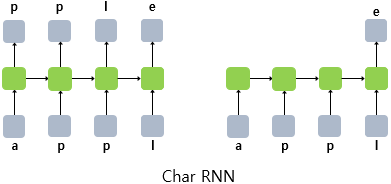

## 3.1 Char RNNLM (Many-to-Many)

### 3.1.1 Data preprocessing

In [23]:
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

In [24]:
urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")
f = open('11-0.txt', 'rb')
lines = []

for line in f:
  line = line.strip() # \r, \n을 제거
  line = line.lower() # 소문자화
  line = line.decode('ascii', 'ignore') # \xe2\x80\x99 등과 같은 바이트 열 제거
  if len(line) > 0:
    lines.append(line)
f.close()

In [25]:
lines[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at']

In [26]:
text = ' '.join(lines)
print(text[:200])

the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost and with


In [27]:
# 글자 집합 생성
char_vocab = sorted(list(set(text)))
vocab_size = len(char_vocab)
print ('글자 집합의 크기 : {}'.format(vocab_size))

글자 집합의 크기 : 56


In [28]:
# 글자-인덱스 사전 생성
char_to_index = dict((c, i) for i, c in enumerate(char_vocab))
print(char_to_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '[': 27, ']': 28, '_': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


In [29]:
# 인덱스-글자 사전 생성
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [30]:
# 문장 샘플의 길이를 정하고, 해당 길이만큼 문자열 전체를 전부 등분
seq_length = 60
n_samples = int((len(text)-1) / seq_length)
print ('문장 샘플의 수 : {}'.format(n_samples))

문장 샘플의 수 : 2658


In [31]:
# 훈련 데이터 - 샘플 데이터 생성
train_X = []
train_y = []

for i in range(n_samples):
    X_sample = text[i*seq_length : (i+1)*seq_length]
    X_encoded = [char_to_index[c] for c in X_sample] # 하나의 문장 샘플에 대해서 정수 인코딩
    train_X.append(X_encoded)

    y_sample = text[i*seq_length + 1 : (i+1)*seq_length + 1] # 오른쪽으로 1칸 쉬프트
    y_encoded = [char_to_index[c] for c in y_sample]
    train_y.append(y_encoded)

In [32]:
print(train_X[0])

[49, 37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30]


In [33]:
print(train_y[0])

[37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30, 43]


In [34]:
# 원-핫 인코딩
# If num_classes = 'None', this would be inferred as the (largest number in 'y') + 1.
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

print('train_X의 크기(shape) : {}'.format(train_X.shape))
print('train_y의 크기(shape) : {}'.format(train_y.shape))

train_X의 크기(shape) : (2658, 60, 56)
train_y의 크기(shape) : (2658, 60, 56)


* (2658, 60, 56) => (number of samples, input_length, input_dim)

### 3.1.2 Modeling

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

In [36]:
model = Sequential()
# model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(256, input_shape=(None, train_X.shape[2]), return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

* ```TimeDistributed```
 * 시간 단계 각각에 독립적으로 레이어를 적용할 수 있음
* ```LSTM(... , input_shape=(None, train_X.shape[2])```
 * A __None__ dimension in a shape tuple means that the network will be able to __accept inputs of any dimension (variable-length sequences)__
 * Convolution layers and recurrent layers such as ```Conv2D``` and ```LSTM``` would support __variably shaped inputs__


In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, None, 256)         320512    
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 256)         525312    
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 56)          14392     
Total params: 860,216
Trainable params: 860,216
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=80, verbose=2)

Epoch 1/80
84/84 - 46s - loss: 3.0665 - accuracy: 0.1815
Epoch 2/80
84/84 - 43s - loss: 2.7231 - accuracy: 0.2483
Epoch 3/80
84/84 - 42s - loss: 2.3802 - accuracy: 0.3318
Epoch 4/80
84/84 - 42s - loss: 2.2402 - accuracy: 0.3648
Epoch 5/80
84/84 - 42s - loss: 2.1429 - accuracy: 0.3890
Epoch 6/80
84/84 - 43s - loss: 2.0606 - accuracy: 0.4088
Epoch 7/80
84/84 - 44s - loss: 1.9929 - accuracy: 0.4266
Epoch 8/80
84/84 - 43s - loss: 1.9289 - accuracy: 0.4432
Epoch 9/80
84/84 - 43s - loss: 1.8775 - accuracy: 0.4557
Epoch 10/80
84/84 - 43s - loss: 1.8275 - accuracy: 0.4703
Epoch 11/80
84/84 - 43s - loss: 1.7819 - accuracy: 0.4826
Epoch 12/80
84/84 - 43s - loss: 1.7414 - accuracy: 0.4931
Epoch 13/80
84/84 - 44s - loss: 1.7075 - accuracy: 0.5018
Epoch 14/80
84/84 - 44s - loss: 1.6687 - accuracy: 0.5116
Epoch 15/80
84/84 - 43s - loss: 1.6330 - accuracy: 0.5212
Epoch 16/80
84/84 - 44s - loss: 1.6032 - accuracy: 0.5291
Epoch 17/80
84/84 - 43s - loss: 1.5687 - accuracy: 0.5377
Epoch 18/80
84/84 - 44s

In [48]:
def sentence_generation(model, length):
  ix = [np.random.randint(vocab_size)] # 랜덤 인덱스 생성
  y_char = [index_to_char[ix[-1]]] # 랜덤 인덱스로부터 첫 글자 생성
  print(ix[-1],'번 글자',y_char[-1],'로 예측을 시작!')
    
  ## (1, length, 56) 크기의 X 생성. 즉, LSTM의 입력 시퀀스 생성
  X = np.zeros((1, length, vocab_size))

  for i in range(length):
    ## X[0][i][예측한 글자의 인덱스] = 1. 
    ## 즉, 예측 시퀀스의 마지막 글자를 다음 입력 시퀀스에 추가
    X[0][i][ix[-1]] = 1

    ## 이전 예측 글자까지의 입력 시퀸스를 새로운 입력으로 예측 수행
    ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1) # 예측 시퀸스의 각 단어의 인덱스 계산
    y_char.append(index_to_char[ix[-1]]) # 예측 시퀸스에서의 마지막 단어만 저장 

  return ''.join(y_char)

In [49]:
sentence_generation(model, 100)

5 번 글자 % 로 예측을 시작!


'% out of the wood soon look at all. the hattem were blaw. into the use of a project gutenberg-tm work'

## 3.2 Char RNNLM (Many-to-One)

### 3.2.1 Data preprocessing

In [41]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [60]:
text = "I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine."

In [61]:
# 글자 집합 생성
char_vocab = sorted(list(set(text)))
print(char_vocab)
vocab_size=len(char_vocab)
print ('글자 집합의 크기 : {}'.format(vocab_size))

[' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']
글자 집합의 크기 : 33


In [62]:
# 글자-인덱스 사전 생성
char_to_index = dict((c, i) for i, c in enumerate(char_vocab))
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


In [63]:
# 모든 입력 시퀸스 샘플들의 길이를 통일
length = 11
sequences = []

for i in range(length, len(text)):
    seq = text[i-length:i]
    sequences.append(seq)
print('총 훈련 샘플의 수: %d' % len(sequences))

총 훈련 샘플의 수: 426


In [64]:
sequences[:10]

['I get on wi',
 ' get on wit',
 'get on with',
 'et on with ',
 't on with l',
 ' on with li',
 'on with lif',
 'n with life',
 ' with life ',
 'with life a']

In [65]:
# 정수 인코딩
X = []

for line in sequences:
    temp_X = [char_to_index[char] for char in line]
    X.append(temp_X)

X[:5]

[[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18],
 [0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28],
 [16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17],
 [14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0],
 [28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]]

In [66]:
# 샘플 데이터와 레이블 데이터 분리
sequences = np.array(X)
X = sequences[:,:-1]
y = sequences[:,-1]

print(X[:5])
print(y[:5])

[[ 8  0 16 14 28  0 24 23  0 31]
 [ 0 16 14 28  0 24 23  0 31 18]
 [16 14 28  0 24 23  0 31 18 28]
 [14 28  0 24 23  0 31 18 28 17]
 [28  0 24 23  0 31 18 28 17  0]]
[18 28 17  0 21]


In [67]:
# 원-핫 인코딩
X = to_categorical(X, num_classes=vocab_size)
y = to_categorical(y, num_classes=vocab_size)

print(X.shape)
print(y.shape)

(426, 10, 33)
(426, 33)


* (426, 10, 33) => (number of samples, input_length, input_dim)

### 3.2.2 Modeling

In [68]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [98]:
model = Sequential()
model.add(LSTM(80, input_shape = (X.shape[1], X.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

In [99]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 80)                36480     
_________________________________________________________________
dense_5 (Dense)              (None, 33)                2673      
Total params: 39,153
Trainable params: 39,153
Non-trainable params: 0
_________________________________________________________________


In [100]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, y, epochs=100, verbose=2)

Epoch 1/100
14/14 - 2s - loss: 3.4658 - accuracy: 0.1338
Epoch 2/100
14/14 - 0s - loss: 3.3381 - accuracy: 0.1972
Epoch 3/100
14/14 - 0s - loss: 3.0740 - accuracy: 0.1972
Epoch 4/100
14/14 - 0s - loss: 2.9847 - accuracy: 0.1972
Epoch 5/100
14/14 - 0s - loss: 2.9500 - accuracy: 0.1972
Epoch 6/100
14/14 - 0s - loss: 2.9308 - accuracy: 0.1972
Epoch 7/100
14/14 - 0s - loss: 2.9047 - accuracy: 0.1972
Epoch 8/100
14/14 - 0s - loss: 2.8796 - accuracy: 0.1972
Epoch 9/100
14/14 - 0s - loss: 2.8571 - accuracy: 0.1972
Epoch 10/100
14/14 - 0s - loss: 2.8182 - accuracy: 0.1972
Epoch 11/100
14/14 - 0s - loss: 2.7723 - accuracy: 0.1972
Epoch 12/100
14/14 - 0s - loss: 2.7363 - accuracy: 0.2230
Epoch 13/100
14/14 - 0s - loss: 2.6850 - accuracy: 0.2160
Epoch 14/100
14/14 - 0s - loss: 2.6257 - accuracy: 0.2394
Epoch 15/100
14/14 - 0s - loss: 2.5793 - accuracy: 0.2371
Epoch 16/100
14/14 - 0s - loss: 2.5269 - accuracy: 0.2441
Epoch 17/100
14/14 - 0s - loss: 2.4822 - accuracy: 0.2700
Epoch 18/100
14/14 - 0s

In [101]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):
# 모델, 글자-인덱스 사진, 문장 길이, 초기 시퀀스, 반복 횟수
    init_text = seed_text # 문장 생성에 사용할 초기 시퀀스
    sentence = ''

    for _ in range(n):
        ## 현재 시퀀스에 대한 정수 인코딩
        encoded = [char_to_index[char] for char in seed_text]
        ## 데이터에 대한 패딩 : 모델의 lstm layer의 input shape의 시퀸스 길이를 10으로 선언했으므로
        encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre')
        ## 원-핫 인코딩
        encoded = to_categorical(encoded, num_classes=len(char_to_index))

        result = model.predict(encoded, verbose=0)
        result = np.argmax(result, axis=1) # 예측 글자 인덱스 

        ## 인덱스로 예측 글자 검색
        for char, index in char_to_index.items():
            if index == result:
                break
        
        seed_text += char # 현재 시퀀스 + 예측 글자로 현재 시퀀스 변경
        sentence = sentence + char # 예측 글자를 문장에 저장

    sentence = init_text + sentence
    return sentence

In [103]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 80))

I get on with life as a programmer, I like to contemplate beer. But when I stor mt ttadddr
